## Aplicación de charapy en caso práctico

In [1]:
import pandas as pd
import numpy as np
import pylab as pl

In [2]:
df1 = pd.read_csv('/home/marlen/disci/charapy/test/data_sets/gas_condensate_mixture.csv')
df2 = pd.read_csv('/home/marlen/disci/charapy/test/data_sets/com.csv')

In [3]:
cn1 = df1['carbon_number'][1:-1]
z1 = df1['mole_percentage'][1:-1]
mw1 = df1['molecular_weight'][1:-1]
rho1 = df1['density'][1:-1]

cn2 = df2['component'][1:-1]
z2 = df2['molar_percentage'][1:-1]
mw2 = df2['molar_mass'][1:-1]
rho2 = df2['density'][1:-1]

In [4]:
from charapy.distributions.pedersen import Distribution_pedersen

dped = Distribution_pedersen()
A1,B1 = dped.fit_AB(z1,cn1)
A2,B2 = dped.fit_AB(z2,cn2)

cn1_pedersen = dped.carbon_number(z1,A1,B1)
cn2_pedersen = dped.carbon_number(z2,A2,B2)

## Analisis grafico PEDERSEN

Text(0.5, 0, 'Carbon number')

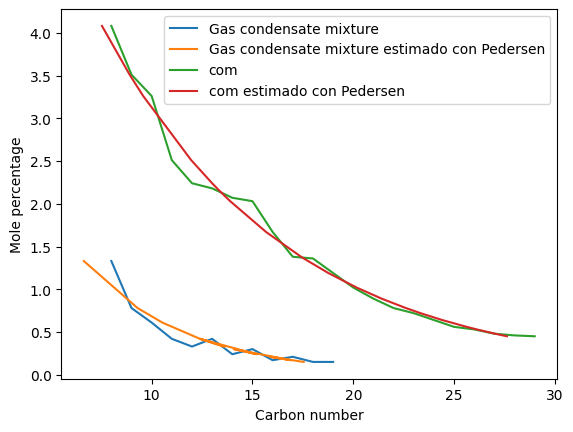

In [5]:
pl.plot(cn1,z1,label='Gas condensate mixture')
pl.plot(cn1_pedersen,z1,label = 'Gas condensate mixture estimado con Pedersen')
pl.plot(cn2,z2,label='com')
pl.plot(cn2_pedersen,z2,label='com estimado con Pedersen')

pl.legend(loc='upper right')
pl.ylabel('Mole percentage')
pl.xlabel('Carbon number')

In [6]:
z1_pedersen = dped.molar_fraction(cn1,A1,B1)
z2_pedersen = dped.molar_fraction(cn2,A2,B2)

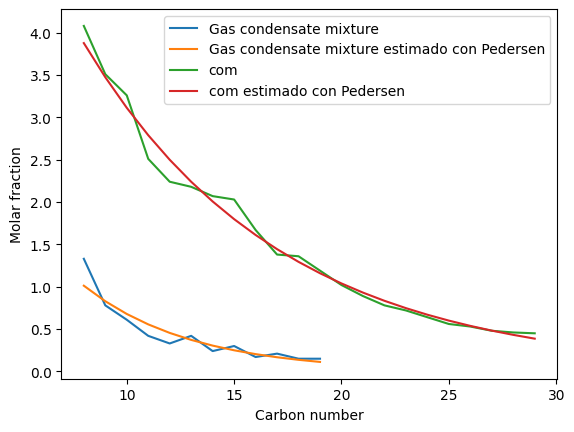

In [7]:
pl.plot(cn1,z1,label='Gas condensate mixture')
pl.plot(cn1,z1_pedersen,label='Gas condensate mixture estimado con Pedersen')

pl.plot(cn2,z2,label='com')
pl.plot(cn2,z2_pedersen,label='com estimado con Pedersen')

pl.xlabel('Carbon number')
pl.ylabel('Molar fraction')
pl.legend(loc='upper right')

In [8]:
L1,M1 = dped.fit_LM(cn1,rho1)
L2,M2 = dped.fit_LM(cn2,rho2)

rho1_pedersen = dped.density(cn1,L1,M1)
rho2_pedersen = dped.density(cn2,L2,M2)

Text(0.5, 0, 'Carbon number')

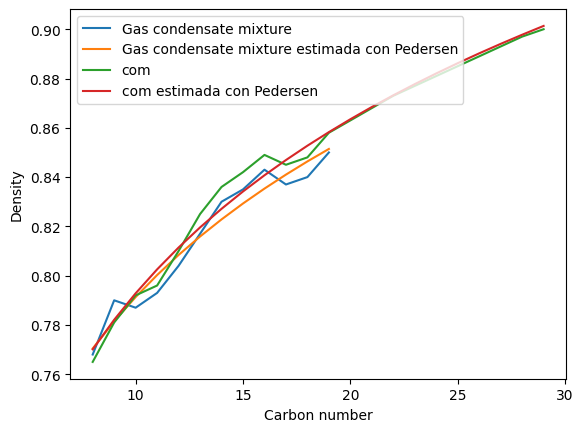

In [9]:
pl.plot(cn1,rho1,label = 'Gas condensate mixture')
pl.plot(cn1,rho1_pedersen,label = 'Gas condensate mixture estimada con Pedersen')

pl.plot(cn2,rho2,label='com')
pl.plot(cn2,rho2_pedersen,label='com estimada con Pedersen')

pl.legend(loc='upper left')
pl.ylabel('Density')
pl.xlabel('Carbon number')

In [10]:
mweight1_pedersen = dped.molecular_weight(cn1)
mweight2_pedersen = dped.molecular_weight(cn2)

Text(0.5, 0, 'Carbon number')

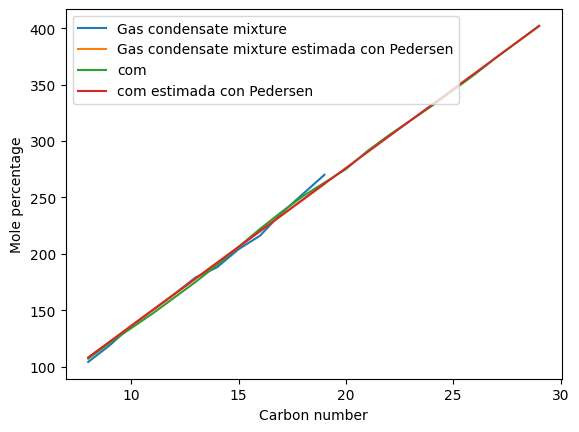

In [11]:
pl.plot(cn1,mw1,label='Gas condensate mixture')
pl.plot(cn1,mweight1_pedersen,label='Gas condensate mixture estimada con Pedersen')

pl.plot(cn2,mw2,label='com')
pl.plot(cn2,mweight2_pedersen,label='com estimada con Pedersen')

pl.legend(loc='upper left')
pl.ylabel('Mole percentage')
pl.xlabel('Carbon number')

## Analisis grafico CISMONDI

In [12]:
from charapy.distributions.cismondi import Distribution_cismondi
dcis = Distribution_cismondi()

In [13]:
Ac1,Bc1 = dcis.fit_ACBC(z1,cn1)
Ac2,Bc2 = dcis.fit_ACBC(z2,cn2)

z1_cismondi = dcis.molar_fraction(cn1,Ac1,Bc1)
z2_cismondi = dcis.molar_fraction(cn2,Ac2,Bc2)

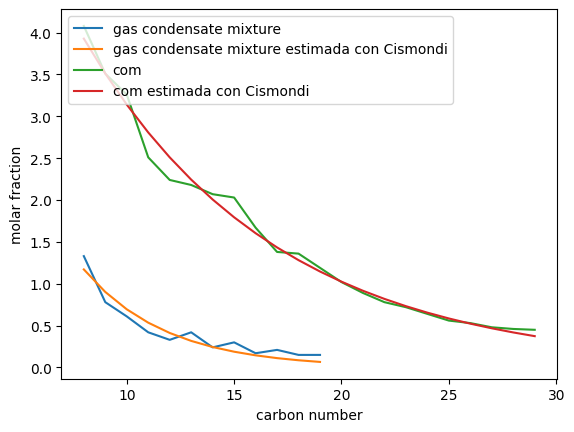

In [14]:
pl.plot(cn1,z1,label='gas condensate mixture')
pl.plot(cn1,z1_cismondi,label='gas condensate mixture estimada con Cismondi')

pl.plot(cn2,z2,label='com')
pl.plot(cn2,z2_cismondi,label='com estimada con Cismondi')

pl.xlabel('carbon number')
pl.ylabel('molar fraction')
pl.legend(loc='upper left')

In [15]:
C1 = dcis.fit_C(cn1,mw1)
C2 = dcis.fit_C(cn2,mw2)

mw1_cismondi = dcis.molecular_weight(cn1,C1)
mw2_cismondi = dcis.molecular_weight(cn2,C2)

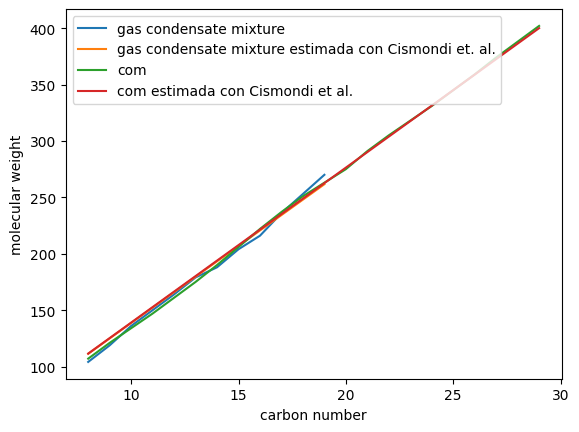

In [16]:
pl.plot(cn1,mw1,label='gas condensate mixture')
pl.plot(cn1,mw1_cismondi,label='gas condensate mixture estimada con Cismondi et. al.')

pl.plot(cn2,mw2,label='com')
pl.plot(cn2,mw2_cismondi,label='com estimada con Cismondi et al.')

pl.xlabel('carbon number')
pl.ylabel('molecular weight')
pl.legend(loc='upper left')

In [17]:
Ad1 = dcis.fit_AD(cn1,rho1)
Ad2 = dcis.fit_AD(cn2,rho2)

rho1_cismondi = dcis.density(cn1,Ad1)
rho2_cismondi = dcis.density(cn2,Ad2)

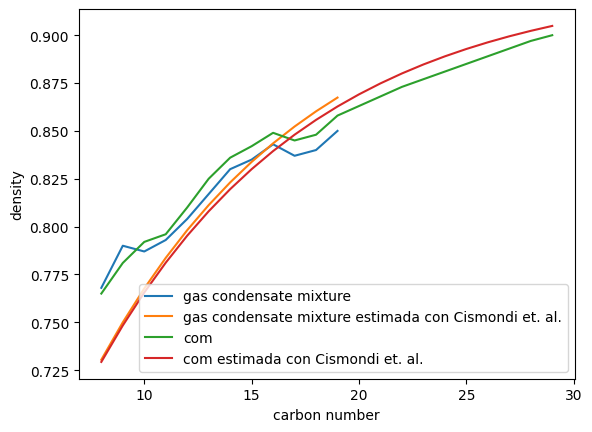

In [18]:
pl.plot(cn1,rho1,label='gas condensate mixture')
pl.plot(cn1,rho1_cismondi,label='gas condensate mixture estimada con Cismondi et. al.')

pl.plot(cn2,rho2,label='com')
pl.plot(cn2,rho2_cismondi,label='com estimada con Cismondi et. al.')

pl.xlabel('carbon number')
pl.ylabel('density')
pl.legend(loc='lower right')

### Numero maximo de carbono a distribuir

In [19]:
cn1_plus = df1['carbon_number'].iloc[-1]
z1_plus = df1['mole_percentage'].iloc[-1]
mw1_plus = df1['molecular_weight'].iloc[-1]
rho1_plus = df1['density'].iloc[-1]

cn2_plus = df2['component'].iloc[-1]
z2_plus = df2['molar_percentage'].iloc[-1]
mw2_plus = df2['molar_mass'].iloc[-1]
rho2_plus = df2['density'].iloc[-1]

In [20]:
from charapy.residual_fraction import Residual_fraction, Proper_plus
pp = Proper_plus()
rf1 = Residual_fraction(mw1_plus,z1_plus)
rf2 = Residual_fraction(mw2_plus,z2_plus)

rango_iteracion1 = np.array(range(cn1_plus,10000,1))
rango_iteracion2 = np.array(range(cn2_plus,10000,1))

cn_maximo1 = rf1.cn_max(rango_iteracion1,A1,B1,'ped')
cn_maximo2 = rf2.cn_max(rango_iteracion2,A2,B2,'cis',C2)

print('Número máximo para la mezcla de gas condensado:',cn_maximo1)
print('Numero maximo para com:', cn_maximo2)

Número máximo para la mezcla de gas condensado: 10000
Numero maximo para com: 10000


# DISTRIBUCION

In [21]:
c_range1 = np.arange(cn1_plus,cn_maximo1+1,1)
c_range2 = np.arange(cn2_plus,cn_maximo2+1,1)

ped_density1 = dped.density(c_range1,L1,M1)
ped_density2 = dped.density(c_range2,L2,M2)

cis_density1 = dcis.density(c_range1,Ad1)
cis_density2 = dcis.density(c_range2,Ad2)

ped_mw1 = dped.molecular_weight(c_range1)
ped_mw2 = dped.molecular_weight(c_range2)

cis_mw1 = dcis.molecular_weight(c_range1,C1)
cis_mw2 = dcis.molecular_weight(c_range2,C2)

ped_mf1 = dped.molar_fraction(c_range1,A1,B1)
ped_mf2 = dped.molar_fraction(c_range2,A2,B2)

cis_mf1 = dcis.molar_fraction(c_range1, Ac1, Bc1)
cis_mf2 = dcis.molar_fraction(c_range2,Ac2,Bc2)

-----------------------------

In [22]:
df1['molar_percentage_pedersen']=df1['mole_percentage']
df2['molar_percentage_pedersen']=df2['molar_percentage']

df1['molar_percentage_cismondi']=df1['mole_percentage']
df2['molar_percentage_cismondi']=df2['molar_percentage']

df1['molecular_weight_pedersen']=df1['molecular_weight']
df2['molecular_weight_pedersen']=df2['molar_mass']

df1['molecular_weight_cismondi']=df1['molecular_weight']
df2['molecular_weight_cismondi']=df2['molar_mass']

df1['density_pedersen']=df1['density']
df2['density_pedersen']=df2['density']

df1['density_cismondi']=df1['density']
df2['density_cismondi']=df2['density']

df1=df1.drop(['molecular_weight','mole_percentage','density'],axis=1)
df2=df2.drop(['molar_mass','molar_percentage','density'],axis=1)

In [23]:
df1['Tc_pedersen']=np.nan
df2['Tc_pedersen']=np.nan
df1['Tc_cismondi']=np.nan
df2['Tc_cismondi']=np.nan
df1['Pc_pedersen']=np.nan
df2['Pc_pedersen']=np.nan
df1['Pc_cismondi']=np.nan
df2['Pc_cismondi']=np.nan

# CORRELACIONES 

In [24]:
from charapy import correlations
corr = correlations.Foon('PR')

tc_ped1=corr.critical_temperature(ped_mw1,ped_density1)
tc_ped2=corr.critical_temperature(ped_mw2,ped_density2)

tc_cis1=corr.critical_temperature(cis_mw1,cis_density1)
tc_cis2=corr.critical_temperature(cis_mw2,cis_density2)

pc_ped1=corr.critical_presion(ped_mw1, ped_density1)
pc_ped2=corr.critical_presion(ped_mw2,ped_density2)

pc_cis1=corr.critical_presion(cis_mw1,cis_density1)
pc_cis2=corr.critical_presion(cis_mw2,cis_density2)

/home/marlen/disci/charapy/charapy/correlations.py:87: RuntimeWarning: overflow encountered in exp
  cP = np.exp(p_log)


In [25]:
for i in range (len(c_range1)):
    df1=pd.concat([df1,
        pd.DataFrame(
        {'carbon_number':c_range1[i],
        'molar_percentage_pedersen':ped_mf1[i],
        'molar_percentage_cismondi':cis_mf1[i],
        'molecular_weight_pedersen':ped_mw1[i],
        'molecular_weight_cismondi':cis_mw1[i],
        'density_pedersen':ped_density1[i],
        'density_cismondi':cis_density1[i], 
        'Tc_pedersen':tc_ped1[i],
        'Tc_cismondi':tc_cis1[i],
        'Pc_pedersen':pc_ped1[i],
        'Pc_cismondi':pc_cis1[i]   
        },index=[c_range1[i]])])
df1

,component,carbon_number,molar_percentage_pedersen,molar_percentage_cismondi,molecular_weight_pedersen,molecular_weight_cismondi,density_pedersen,density_cismondi,Tc_pedersen,Tc_cismondi,Pc_pedersen,Pc_cismondi
0,C7,7,1.33,1.33,91.3,91.300000,0.746000,0.746000,NaN,NaN,NaN,NaN
1,C8,8,1.33,1.33,104.1,104.100000,0.768000,0.768000,NaN,NaN,NaN,NaN
2,C9,9,0.78,0.78,118.8,118.800000,0.790000,0.790000,NaN,NaN,NaN,NaN
3,C10,10,0.61,0.61,136.0,136.000000,0.787000,0.787000,NaN,NaN,NaN,NaN
4,C11,11,0.42,0.42,150.0,150.000000,0.793000,0.793000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,NaN,9996,0.00,0.00,139940.0,136592.831297,1.438021,0.935744,87844.641581,85734.338806,inf,1.632235
9997,NaN,9997,0.00,0.00,139954.0,136606.495845,1.438031,0.935744,87853.314570,85742.803552,inf,1.632235
9998,NaN,9998,0.00,0.00,139968.0,136620.160392,1.438040,0.935744,87861.987559,85751.268297,inf,1.632235
9999,NaN,9999,0.00,0.00,139982.0,136633.824940,1.438050,0.935744,87870.660546,85759.733041,inf,1.632235


In [26]:
for i in range (len(c_range2)):
    df2=pd.concat([df2,
        pd.DataFrame(
        {'component':c_range2[i],
        'molar_percentage_pedersen':ped_mf2[i],
        'molar_percentage_cismondi':cis_mf2[i],
        'molecular_weight_pedersen':ped_mw2[i],
        'molecular_weight_cismondi':cis_mw2[i],
        'density_pedersen':ped_density2[i],
        'density_cismondi':cis_density2[i], 
        'Tc_pedersen':tc_ped2[i],
        'Tc_cismondi':tc_cis2[i],
        'Pc_pedersen':pc_ped2[i],
        'Pc_cismondi':pc_cis2[i]   
        },index=[c_range2[i]])])
df2

,component,molar_percentage_pedersen,molar_percentage_cismondi,molecular_weight_pedersen,molecular_weight_cismondi,density_pedersen,density_cismondi,Tc_pedersen,Tc_cismondi,Pc_pedersen,Pc_cismondi
0,7,2.87,2.87,96.0,96.000000,0.738000,0.738000,NaN,NaN,NaN,NaN
1,8,4.08,4.08,107.0,107.000000,0.765000,0.765000,NaN,NaN,NaN,NaN
2,9,3.51,3.51,121.0,121.000000,0.781000,0.781000,NaN,NaN,NaN,NaN
3,10,3.26,3.26,134.0,134.000000,0.792000,0.792000,NaN,NaN,NaN,NaN
4,11,2.51,2.51,147.0,147.000000,0.796000,0.796000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,9996,0.00,0.00,139940.0,137353.486468,1.496757,0.929346,87848.953030,86205.068975,inf,1.528660
9997,9997,0.00,0.00,139954.0,137367.227157,1.496767,0.929346,87857.626081,86213.580832,inf,1.528659
9998,9998,0.00,0.00,139968.0,137380.967847,1.496778,0.929346,87866.299130,86222.092689,inf,1.528659
9999,9999,0.00,0.00,139982.0,137394.708536,1.496788,0.929346,87874.972178,86230.604544,inf,1.528659


In [27]:
from charapy import lumping
lp = lumping.Lumping()

dat1 = lp.lumpy([
    (7,11),(12,14),(15,18),(19,22),(23,25),
    (26,30),(31,34),(35,38),(39,49),(50,100),
    (101,1000),(1001,5000),(5001,10000)], df1,
    'carbon_number')
dat1

/home/marlen/disci/charapy/charapy/lumping.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dropna=False).mean()


,carbon_number,molar_percentage_pedersen,molar_percentage_cismondi,molecular_weight_pedersen,molecular_weight_cismondi,density_pedersen,density_cismondi,Tc_pedersen,Tc_cismondi,Pc_pedersen,Pc_cismondi
ID,,,,,,,,,,,
0.0,"(7, 11)",8.940000e-01,8.940000e-01,120.04,120.040000,0.776800,0.776800,NaN,NaN,NaN,NaN
1.0,"(12, 14)",3.300000e-01,3.300000e-01,177.00,177.000000,0.817000,0.817000,NaN,NaN,NaN,NaN
2.0,"(15, 18)",2.075000e-01,2.075000e-01,227.25,227.250000,0.838750,0.838750,NaN,NaN,NaN,NaN
3.0,"(19, 22)",2.356669e-01,2.141108e-01,306.20,305.580929,0.861832,0.873165,83.298594,81.208431,1.901173e+00,1.977032
4.0,"(23, 25)",4.176096e-02,1.835777e-02,332.00,329.961858,0.873238,0.894158,213.592447,209.459981,1.830348e+00,1.948315
5.0,"(26, 30)",1.926012e-02,6.753688e-03,388.00,384.620049,0.887605,0.907682,353.274699,347.175854,1.788450e+00,1.950192
6.0,"(31, 34)",7.712722e-03,2.033880e-03,451.00,446.110513,0.901622,0.917918,482.978321,475.093554,1.789123e+00,1.969561
7.0,"(35, 38)",3.464456e-03,7.156030e-04,507.00,500.768704,0.912501,0.923795,580.431017,571.151763,1.827845e+00,1.985966
8.0,"(39, 49)",9.136305e-04,1.332670e-04,612.00,603.252812,0.929798,0.929850,733.080675,721.406373,1.998639e+00,1.994172


In [31]:
dat2 = lp.lumpy([
    (7,11),(12,14),(15,18),(19,22),(23,25),
    (26,30),(31,34),(35,38),(39,49),(50,100),
    (101,1000),(1001,5000),(5001,10000)], df2,
    'component')

dat2

,component,molar_percentage_pedersen,molar_percentage_cismondi,molecular_weight_pedersen,molecular_weight_cismondi,density_pedersen,density_cismondi,Tc_pedersen,Tc_cismondi,Pc_pedersen,Pc_cismondi
ID,,,,,,,,,,,
0.0,"(7, 11)",3.246000e+00,3.246000e+00,121.000000,121.000000,0.774400,0.774400,NaN,NaN,NaN,NaN
1.0,"(12, 14)",2.163333e+00,2.163333e+00,175.333333,175.333333,0.823667,0.823667,NaN,NaN,NaN,NaN
2.0,"(15, 18)",1.610000e+00,1.610000e+00,229.000000,229.000000,0.846000,0.846000,NaN,NaN,NaN,NaN
3.0,"(19, 22)",9.700000e-01,9.700000e-01,283.500000,283.500000,0.865500,0.865500,NaN,NaN,NaN,NaN
4.0,"(23, 25)",6.400000e-01,6.400000e-01,331.333333,331.333333,0.881000,0.881000,NaN,NaN,NaN,NaN
5.0,"(26, 30)",2.037764e+00,2.035740e+00,398.016667,397.646091,0.912133,0.912530,415.883903,411.501250,1.864339,1.890731
6.0,"(31, 34)",2.653990e-01,2.547622e-01,451.000000,448.128267,0.912893,0.911975,483.805668,478.424791,1.900249,1.892175
7.0,"(35, 38)",1.710896e-01,1.627838e-01,507.000000,503.091025,0.924735,0.917702,581.329025,574.491124,1.996238,1.894049
8.0,"(39, 49)",7.912073e-02,7.419430e-02,612.000000,606.146195,0.943563,0.923602,734.091035,724.838658,2.353559,1.884913
